In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import daft

# Probabilistic Graphical Models (PGMs)

*By [Adrian Price-Whelan](https://adrian.pw/)*

Graphical models are a useful tool for constructing probabilistic models. In one sentence, probabilistic graphical models (PGMs) use concepts from [graph theory](https://en.wikipedia.org/wiki/Graph_theory) to help represent and conceptualize the complex relationships between random variables in probabilistic models. When visualized as graph diagrams, PGMs are useful for understanding models, for debugging, and for thinking about extensions or generalizations of models. I find them primarily useful for visualization and mapping out a model once I have an idea of how I will write it down, but you can also start thinking about a model in the context of PGMs: I often find logical errors or bugs in code from comparing my ideas about a model, with a PGM representation, with the code that implements a model. Let's dive in.

## Graph theory basics and terminology

I am definitely not an expert in graphs or graph theory, but luckily there are only a few key concepts to know before we get on to talking about PGMs in practice.

First, what is a *graph*? A graph is a structure that lets us express relationships between pairs of objects that together might belong to a larger, coherent network. A graph is made of *vertices*, which represent the objects, and *edges*, which represent the relationships between objects. The edges in a graph can either have a direction associated with them, or be undirected. These lead to graphs that are either *directed* or *undirected*, respectively.

#### Undirected graphs
An example of an *undirected graph* is your network of Facebook friends: When you become friends with someone, they become friends with you. There is no meaning of the "direction" of a friendship (well, on Facebook at least). Another example of an undirected graph is a subway or train map. For example, an undirected graph to represent a small section of the NYC subway system is shown below (drawn with [daft](https://docs.daft-pgm.org/)). Here, the vertices or *nodes* of the graph are the subway stations, and train paths or connections are shown as edges.

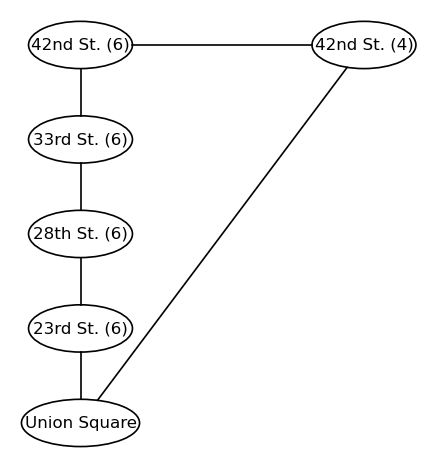

In [2]:
pgm = daft.PGM(dpi=120)

pgm.add_node("usq", "Union Square", 0, 0, aspect=2.5)
pgm.add_node("23 (6)", "23rd St. (6)", 0, 1, aspect=2.2)
pgm.add_node("28 (6)", "28th St. (6)", 0, 2, aspect=2.2)
pgm.add_node("33 (6)", "33rd St. (6)", 0, 3, aspect=2.2)
pgm.add_node("42 (6)", "42nd St. (6)", 0, 4, aspect=2.2)
pgm.add_node("42 (4)", "42nd St. (4)", 3, 4, aspect=2.2)

pgm.add_edge("usq", "23 (6)", directed=False)
pgm.add_edge("23 (6)", "28 (6)", directed=False)
pgm.add_edge("28 (6)", "33 (6)", directed=False)
pgm.add_edge("33 (6)", "42 (6)", directed=False)
pgm.add_edge("usq", "42 (4)", directed=False)
pgm.add_edge("42 (6)", "42 (4)", directed=False)

pgm.render();

#### Directed graphs
*Directed graphs* are useful for representing networks where there are asymmetries between objects / vertices, or where there is an implied directionality in relationships between vertices. One example of a *directed graph* is a family tree: In this case, the vertices are family members and the edges represent relationships (genealogical or adopted) between family members. An example for a family is shown below (again drawn with [daft](https://docs.daft-pgm.org/)).

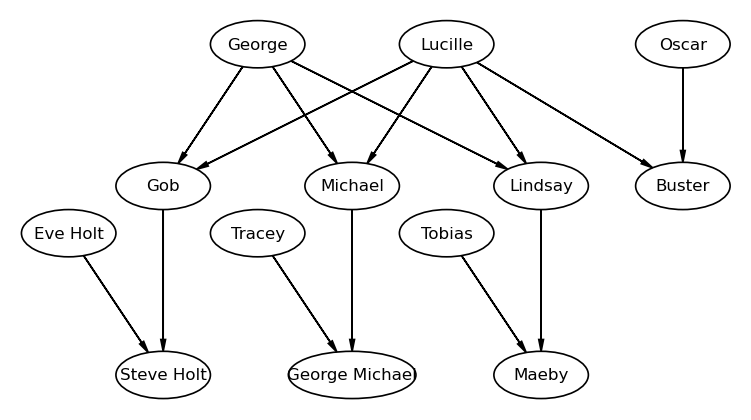

In [3]:
pgm = daft.PGM(dpi=120)

pgm.add_node("George", "George", 0, 0, aspect=2.0)
pgm.add_node("Lucille", "Lucille", 2, 0, aspect=2.0)
pgm.add_node("Oscar", "Oscar", 4.5, 0, aspect=2.0)
pgm.add_node("Gob", "Gob", -1, -1.5, aspect=2.0)
pgm.add_node("Eve Holt", "Eve Holt", -2, -2, aspect=2.0)
pgm.add_node("Michael", "Michael", 1, -1.5, aspect=2.0)
pgm.add_node("Tracey", "Tracey", 0, -2, aspect=2.0)
pgm.add_node("Lindsay", "Lindsay", 3, -1.5, aspect=2.0)
pgm.add_node("Tobias", "Tobias", 2, -2, aspect=2.0)
pgm.add_node("Buster", "Buster", 4.5, -1.5, aspect=2.0)
pgm.add_node("Steve Holt", "Steve Holt", -1, -3.5, aspect=2.0)
pgm.add_node("George Michael", "George Michael", 1, -3.5, aspect=2.7)
pgm.add_node("Maeby", "Maeby", 3, -3.5, aspect=2)

pgm.add_edge("George", "Gob")
pgm.add_edge("George", "Michael")
pgm.add_edge("George", "Lindsay")
pgm.add_edge("Lucille", "Gob")
pgm.add_edge("Lucille", "Michael")
pgm.add_edge("Lucille", "Lindsay")
pgm.add_edge("Lucille", "Buster")
pgm.add_edge("Oscar", "Buster")
pgm.add_edge("Gob", "Steve Holt")
pgm.add_edge("Eve Holt", "Steve Holt")
pgm.add_edge("Michael", "George Michael")
pgm.add_edge("Tracey", "George Michael")
pgm.add_edge("Lindsay", "Maeby")
pgm.add_edge("Tobias", "Maeby")

pgm.render();

In all model-building contexts I have come across, and in places where I have used PGMs, I have used *directed acyclic graphs*. We already know what "directed" means, but what does *acyclic* mean? This refers to the fact that there are no closed loops (i.e. cycles) in the graph. A directed graph with a cycle would look like:

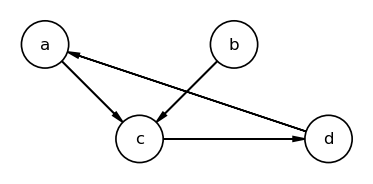

In [4]:
pgm = daft.PGM(dpi=120)

pgm.add_node("a", "a", 0, 0)
pgm.add_node("b", "b", 2, 0)
pgm.add_node("c", "c", 1, -1)
pgm.add_node("d", "d", 3, -1)

pgm.add_edge("a", "c")
pgm.add_edge("b", "c")
pgm.add_edge("c", "d")
pgm.add_edge("d", "a")

pgm.render();

In the above example, the cycle a-c-d-a is a closed loop. For today, we will not come across any models or probability functions that include these cycles, so we will focus on *Directed Acyclic Graphs* or DAGs.

## Representing probabilistic models with directed acyclic graphs (DAGs)

In the context of PGMs, the vertices of a DAG represent either random variables or input data, and the edges represent the relationships between these things. The key concept to come to (and it took me a while to get this!) is that a graph representation of a model gives you a map of ways you can factorize the joint probability distribution over all of your random variables and data. Let's look at this with an example model in mind to help us unpack those statements.

### Example: The distance to a star given its parallax

Let's start with a problem that is always on my mind in this era of Gaia: We are given the parallax of a star and we want to infer its distance. To do this, we will construct a probabilistic model that generates the observed data given some parameters (i.e. a "generative model"). In this case, the generative model is simple: the uncertainties that Gaia reports are Gaussian, so we assume that the observed parallax $\varpi$ of a star is generated with distance $r$ as:

$$
\varpi = 1 / r + \textrm{noise}
$$

In this model, we have just one unobserved random variable: the distance $r$ that we would like to infer. A PGM for this model would look like:

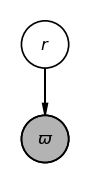

In [5]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)

pgm.add_edge("r", "plx")

pgm.render();

The gray vertex in this graph comes from a common convention in drawing PGMs in which observed quantities (i.e. data) are shaded, whereas unobserved quantities are drawn as empty circles. Now, up above I stated that "a graph representation of a model gives you a map of ways you can factorize the joint probability distribution over all of your random variables and data." What does that mean for this example? 

The joint probability distribution function for this model is $p(\textrm{everything})$, or:

$$
p(r, \varpi)
$$

The graph tells us that one way to factorize this joint distribution is as

$$
p(r, \varpi) = p(\varpi | r) \, p(r)
$$

I got there by starting from the observed vertex (i.e. $\varpi$ at the bottom), writing $p(\varpi|$ and putting any variable that points directly to $\varpi$ after the conditional bar. In this case, that is just the distance $r$. That gives us the first term in our factorization: $p(\varpi | r)$. Then, we go to each variable that points at $\varpi$ and do the same thing. In this case, we write $p(r | $, but nothing points to $r$, so there is nothing to put after the conditional. We are done already having just two terms: $p(\varpi | r)$ and $p(r)$. (We will see more complicated models later!)

This is a valid PGM, but I want to introduce one other convention that you may sometimes encounter (and is useful to build up to hierarchical models later). What is $p(r)$ in the factorization above? This is a prior probability distribution over the distance $r$! In the model above, we haven't actually specified what this prior distribution is. In this particular example (distance inference from a parallax), a common choice might be to assume an [*exponentially decreasing volume density prior*](https://arxiv.org/abs/1507.02105) that looks like

$$
p(r) = \frac{1}{2\,L^3} \, \frac{r^2}{e^{r/L}}
$$

This prior pdf has its own parameter $L$ that we have to fix before we go about our inference here. As a way of indicating this in a PGM, you may sometimes see fixed prior parameters appear as their own vertices in a PGM:

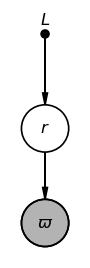

In [6]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)
pgm.add_node("L", "$L$", 0, 2, fixed=True)

pgm.add_edge("r", "plx")
pgm.add_edge("L", "r")

pgm.render();

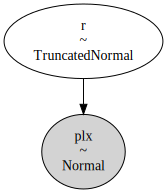

In [7]:
import pymc as pm

with pm.Model() as model:
    r = pm.TruncatedNormal(
        "r",
        mu=1.0,
        sigma=1.0,
        lower=0,
        upper=np.inf,
    )
    plx = pm.Normal("plx", mu=1 / r, observed=1.25, sigma=0.21)

pm.model_to_graphviz(model)

However, to indicate that this parameter $L$ is not a random variable but rather is a hard-set value, these are drawn as a filled black dot like in the above graph. The fact that $L$ is a fixed value is also why it doesn't appear in the specification of the probability of $r$: only random variables appear in pdfs (on either side of the conditional bar).

### Problem 1: Inferring the tangential velocity and distance of a star

We are given the observed parallax $\varpi$ and total proper motion $\mu$ (i.e. the scalar $\mu = \sqrt{\mu_\alpha^2 + \mu_\delta^2} = v_{\textrm{tan}} / r$). Use the `daft` package as above, or a sheet of paper, or a whiteboard to draw a graphical model for a model in which we would like to infer the tangential velocity $v_\textrm{tan}$ *and* the distance $r$ given the observed total proper motion $\mu$ and parallax $\varpi$.

### Problem 2: Inferring the distance to a cepheid using a period–luminosity relation

We are given the observed period $P$ and mean flux $\langle f \rangle$ of a pulsating variable star, e.g., a Cepheid. We know that Cepheids obey a period–luminosity relation, so that the mean luminosity $\mathcal{L}$ of a Cepheid can be predicted once its period is known following the relation:

$$
\mathcal{L} = a\,P + b
$$

where $a$ and $b$ are known values that have been previously calibrated and, here, fixed. We want to infer the distance and luminosity of a Cepheid given its period $P$ and (bolometric) mean flux $\langle f \rangle$.

Note also that

$$
\mathcal{\langle f \rangle} = \frac{\mathcal{L}}{4\pi \, r^2}
$$

Use the `daft` package as above, or a sheet of paper, or a whiteboard to draw a graphical model for this model.

### Example: Fitting a sinusoid to data

As another example, we'll move on to another problem motivated by variable star observations: Our goal is to infer the period, amplitude, and mean flux for a star that is observed to display periodic, sinusoidal variability. 

We will assume that the times of observation (i.e. the times at which we have flux measurements) are known precisely enough such that we can ignore measurement uncertainty on the times, but the fluxes have Gaussian uncertainties due to the faintness of the star. Our observed data are then the times $t_n$ (where the subscript $n$ refers to the index of the observation number), the set of fluxes $f_n$, and the flux uncertainties $\sigma_n$, and we will assume we have $N=64$ observations.

Under the assumption that the flux variability is sinusoidal with a mean flux $f_0$, our physical model for the flux $f$ as a function of time $t$ given amplitudes $a,b$ and period $P$ might look like:

$$
f(t) = f_0 + a\,\cos\left(\frac{2\pi \, t}{P}\right) + b\,\sin\left(\frac{2\pi \, t}{P}\right)
$$

In this case, we have 4 random variables $f_0, a, b, P$ — i.e. the parameters of our physical model — the data are measured fluxes $f_n$, and we are given perfectly-known metadata for each flux observation in the times $t_n$ and flux uncertainties $\sigma_n$. A PGM for this model (without specifying fixed parameters of the prior pdfs) is shown below:

In [ ]:
pgm = daft.PGM(dpi=120)

pgm.add_node("a", "$a$", 0, 1)
pgm.add_node("b", "$b$", 1, 1)
pgm.add_node("P", "$P$", 2, 1)
pgm.add_node("f_0", "$f_0$", 3, 1)

pgm.add_node("f_n", "$f_n$", 1.5, 0, observed=True)
pgm.add_node("t_n", "$t_n$", 2.5, 0.25, fixed=True)
pgm.add_node("sigma_n", r"$\sigma_n$", 2.5, -0.25, fixed=True)

pgm.add_edge("a", "f_n")
pgm.add_edge("b", "f_n")
pgm.add_edge("P", "f_n")
pgm.add_edge("f_0", "f_n")
pgm.add_edge("t_n", "f_n")
pgm.add_edge("sigma_n", "f_n")

pgm.add_plate([0.25, -0.5, 2.5, 1.125], label=r"$n = 1, \cdots, N$", shift=-0.125)

pgm.render();

Reading the graph, if we want to generate an observed flux $f_n$, we need values for the four parameters $f_0, a, b, P$, a measurement time $t_n$, and an uncertainty $\sigma_n$. So what is the extra box here? The rectangle is called a *plate* — plates are used to denote when some part of a graph should be repeated. In our example, this plate indicates that the individual measurements $f_n$ are conditionally independent and this part of the graph should be repeated $N$ times.

We can see what this means for factorization of the joint pdf — let's start by writing down the joint pdf for this model:

$$
p(a, b, P, f_0, \{f_n\}_N)
$$

(where $\{f_n\}_N$ represents the set of all $N$ flux measurements). Using the same procedure we used above to factorize the parallax model, we can see that the only observed variables here are the fluxes $f_n$, so

$$
p(a, b, P, f_0, \{f_n\}_N) = p(\{f_n\}_N | a, b, P, f_0) \, p(a) \, p(b) \, p(P) \, p(f_0)
$$

We can go one step further to expand the factorization using the fact that the plate in the PGM implies that the flux measurement $f_n$ are conditionally independent - this means that we can turn the probability of the set of all flux measurements into a product over the probability for each flux measurement individually, i.e.

$$
p(\{f_n\}_N | a, b, P, f_0) = \prod_n^N p(f_n | a, b, P, f_0)
$$

so that the full factorization is:

$$
p(a, b, P, f_0, \{f_n\}_N) = p(a) \, p(b) \, p(P) \, p(f_0) \, \prod_n^N p(f_n | a, b, P, f_0)
$$

### Problem 3: Fitting a straight line to data

We now have all of the tools we need to write down a graphical model for a classic problem: fitting a straight line to data. In this problem, we observe data $y$ with uncertainty $\sigma_y$ as a function of some other quantity $x$ that we assume has negligible uncertainty. We would like to infer the slope $m$ and intercept $b$ of a linear model given the data such that our parametric, generative model for the true $y$ values is:

$$
y = m\,x + b
$$

For this parametric model, and assuming Gaussian uncertainties, the likelihood is:

$$
p(y \,|\, m, b) = \mathcal{N}(y \,|\, m\,x + b, \sigma_y^2)
$$

where $\mathcal{N}(x \,|\, \mu, \sigma^2)$ represents a univariate normal distribution with mean $\mu$ and variance $\sigma^2$ (i.e. $\sigma$ is the standard deviation), i.e.

$$
\mathcal{N}(x \,|\, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi} \, \sigma} \, 
    \exp\left[-\frac{(x - \mu)^2}{2\,\sigma^2} \right]
$$

The posterior pdf is:

$$
p(m, b \,|\, \{y\}_N) 
    \propto \left[\prod_n^N \mathcal{N}(y_n \,|\, m\,x_n + b, \sigma_{y, n}^2) \right] \, p(m) \, p(b)
$$

Use the daft package as above, or a sheet of paper, or a whiteboard to draw a graphical model for this model.

### Problem 4: Inferring the radial velocity of a star from an Echelle spectrum

We are given an [Echelle spectrum](https://en.wikipedia.org/wiki/Echelle_grating) for a star and would like to measure the radial velocity of the star. The details aren't critical for this example, but briefly, an Echelle spectrograph splits different sections of a spectrum (in wavelength) into different chunks that land on different parts of the detector, leading to a 2D dispersed spectrum. For example, the below shows a high resolution spectrum of the Sun where each row is a different spectral order:

![Image](echelle_spect.jpg "echelle spectrum of the Sun")

Our goal now is to write down a graphical model for this inference problem. 

The spectrum is split into $K$ different spectral orders, indexed by $k$. Assume we have extracted the 2D spectrum into $K$ 1D spectra that give us the flux $f_k$ as a function of wavelength $\lambda_k$ for each spectral order $k$, evaluated on an (oversampled) pixel grid set by the detector. The full arrays of flux and wavelength are $f$ and $\lambda$.

To determine the radial velocity, we will fit for the centroid and widths of all spectral lines assuming they are Gaussian, and the local slope of the spectrum (assuming that the continuum of the spectrum is linear within each order). *Note: these are not great assumptions for working with real data!* Once we get the observed line locations, we can then compare to laboratory values to obtain the radial velocity (i.e. the RV won't appear in this model explicitly).

Over the whole spectrum, there are $M$ spectral lines, indexed by $m$, and each spectral line has a centroid or mean location in wavelength $\mu_m$ and a standard deviation $\sigma_m$. The continuum flux in each spectral order $k$ has a slope $a_k$ and an offset $b_k$. 

Use the `daft` package as above, or a sheet of paper, or a whiteboard to draw a graphical model for this model. For tihs problem, there are multiple ways of constructing this PGM, so keep an open mind if you and your group members have different ideas!

## Preview of tomorrow: Hierarchical models

You have now seen and worked with all of the main building blocks of a probabilistic graphical model — well done! As a final point of discussion, we are going to see an example of a PGM that leads naturally in the direction of tomorrow's topic: Hierarchical models. 

### Example: The mean distance of a star cluster

In the example above, we inferred the distance to a single star given a prior for its distance and a measurement of its parallax. But what if we want to infer the mean distance of an object like a star cluster given a bunch of $N$ parallax measurements $\varpi$ and uncertainties $\sigma_\varpi$ for stars (indexed by $n$) in the cluster? Let's assume that the true line-of-sight distance distribution of this star cluster can be well-approximated as a Gaussian with a mean $\mu_r$ and standard deviation $\sigma_r$. This is an example of a simple *hierarchical model*: We need to replace our fixed prior for the stellar distances with a distribution that has its own unknown parameters that we want to learn. In this model, we will want to infer the individual "true" distances $r_n$ to each star and also the mean distance and width of the distance distribution (i.e. the size of the cluster).

If we fixed the mean distance and width of the cluster, this would look like a normal, "one-level" model like the ones we explored above:

In [ ]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)
pgm.add_node("mu", r"$\mu_r$", -0.5, 2, fixed=True)
pgm.add_node("std", r"$\sigma_r$", 0.5, 2, fixed=True)
pgm.add_node("err", r"$\sigma_\varpi$", 1, 0, fixed=True)

pgm.add_edge("r", "plx")
pgm.add_edge("mu", "r")
pgm.add_edge("std", "r")
pgm.add_edge("err", "plx")

pgm.render();

However, because we have $N$ stars that each have their own parallax and true distance values, and we want to *infer* $\mu_r$ instead of fixing it, we need to (1) add a plate to this PGM, and (2) make $\mu_r$ and $\sigma_r$ random variables:

In [ ]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)
pgm.add_node("mu", r"$\mu_r$", -0.5, 2)
pgm.add_node("std", r"$\sigma_r$", 0.5, 2)
pgm.add_node("err", r"$\sigma_\varpi$", 1, 0, fixed=True)

pgm.add_edge("r", "plx")
pgm.add_edge("mu", "r")
pgm.add_edge("std", "r")
pgm.add_edge("err", "plx")

pgm.add_plate([-1.25, -0.5, 2.5, 2], label=r"$n = 1...N$", position="bottom left")

pgm.render();

In math, we can use this PGM to read how to factorize the joint probability over all of the variables here:

$$
p(\{\varpi_n\}, \{r_n\}, \mu_r, \sigma_r) = 
    \left[ \prod_n^N p(\varpi_n | r_n) \, p(r_n | \mu_r, \sigma_r) \right] p(\mu_r) \, p(\sigma_r)
$$

---

Other material on PGMs:
- [Probabilistic Graphical Models](https://mitpress.mit.edu/9780262013192/probabilistic-graphical-models/) (the book) by Daphne Koller and Nir Friedman
- [Probabilistic Graphical Models](https://www.coursera.org/learn/probabilistic-graphical-models) (the coursera course) taught by Daphne Koller
- [Examples in the daft documentation](https://docs.daft-pgm.org/en/latest/examples/)